In [493]:
import numpy as np
import pandas as pd
# import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.regression.linear_model as rg
import arch.unitroot as at
from sklearn import preprocessing
import statsmodels.api as sm
import seaborn as sn

In [494]:
#path = 'C:/Users/vinicius_coin/Desktop/DADOS_MESTRADO/bovesparser-master/data/RESULTSET/'
#dfbovespa = pd.read_csv(path+"dataset_unificado.csv", sep = ';',encoding="ISO-8859-1")
path = 'C:/Users/vinicius_coin/Desktop/DADOS_MESTRADO/bovesparser-master/data/PREBASE/'
dfbovespa = pd.read_csv(path+"COTACOES_consolidado.csv", sep = ';',encoding="ISO-8859-1")

In [495]:
ibovespa = pd.read_csv("C:/Users/vinicius_coin/Desktop/DADOS_MESTRADO/bovesparser-master/data/APOIO/ibovespa.csv", sep = ',',encoding="ISO-8859-1",usecols = ["Date","Close"])
ibovespa["Date"] = pd.to_datetime(ibovespa["Date"])

In [496]:
#DEFINIR AÇÕES A SEREM ESTUDADAS
acao1 = 'BRAP4'
acao2 = 'GGBR4'

df_acao1 = dfbovespa[dfbovespa["cod_papel"] == acao1]
df_acao2 = dfbovespa[dfbovespa["cod_papel"] == acao2]


#Cria um dataframe com a data como index e cada ativo como coluna (valores de fechamento das cotações para cada data)
df_comp = pd.DataFrame()
df_comp['data_pregao'] =  pd.to_datetime(df_acao1['data_pregao'].values)
df_comp[acao1] =  df_acao1['preco_ultimo'].values
df_comp[acao2] =  df_acao2['preco_ultimo'].values
df_comp = pd.merge(df_comp, ibovespa, how = 'left', left_on='data_pregao', right_on='Date')
df_comp = df_comp.rename(columns={"Close": "ibovespa"})
df_comp = df_comp.drop(['Date'], axis=1)
df_comp.set_index('data_pregao', inplace=True)
df_comp_bkp = df_comp.copy()
len(df_comp)

2472

In [497]:
# DEFINIÇÃO DE TRAIN and TEST DATSETS
train_df = df_comp['2018-04-30':'2019-06-30']
test_df = df_comp['2019-07-01':'2019-12-31']
test_df.head()

,BRAP4,GGBR4,ibovespa
data_pregao,,,
2019-07-01,33.64,15.03,101340.0
2019-07-02,32.30,14.64,100605.0
2019-07-03,32.55,14.88,102043.0
2019-07-04,32.43,15.30,103636.0
2019-07-05,31.54,15.37,104089.0



== pairs Returns Correlation ==

        BRAP4   GGBR4
BRAP4  1.0000  0.5182
GGBR4  0.5182  1.0000



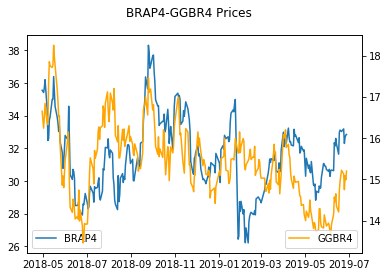

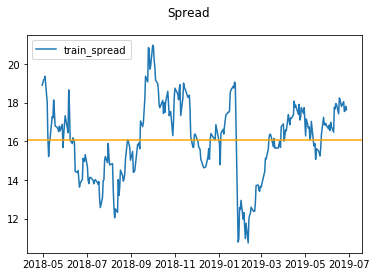

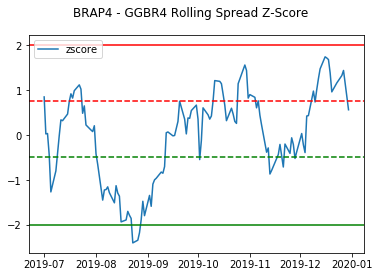

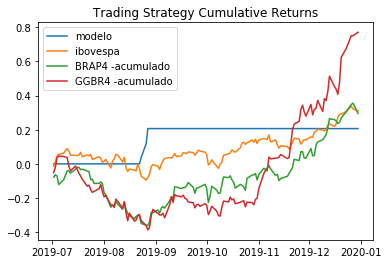


== BRAP4 - GGBR4 Strategy Performace Summary ==

                    0       1         2       3       4
0         Annualized:   model  ibovespa   BRAP4   GGBR4
1              Return  0.2066    0.3094  0.2949  0.7707
2  Standard Deviation  0.0811    0.1595  0.2676  0.3309
3       Sharpe Ratio   2.5487    1.9404   1.102  2.3291


In [498]:
# Cointegração de pares

train_df_acao1 = train_df[acao1]
train_df_acao2 = train_df[acao2]
train_df_ibovespa = train_df["ibovespa"]
result_train_acao1 = train_df_acao1.pct_change(1).dropna()
result_train_acao2 = train_df_acao2.pct_change(1).dropna()
result_train_ibovespa = train_df_ibovespa.pct_change(1).dropna()

# Correlação dos retornos
print('')
print('== pairs Returns Correlation ==')
print('')
print(np.round(pd.DataFrame(result_train_acao1).join(result_train_acao2).corr(), 4))
print('')

# gráfico de preços dos ativos
fig1, ax1 = plt.subplots()
ax1.plot(train_df_acao1)
ax1.legend(loc='lower left')
ax2 = ax1.twinx()
ax2.plot(train_df_acao2, color='orange')
ax2.legend(loc='lower right')
plt.suptitle(acao1+'-'+acao2+ ' Prices')
plt.show()

##########

# 4. Pairs Spread Co-Integration

# 4.1. Spread Calculation
#train_spread = train_df_acao1 - rg.OLS(train_df_acao1, train_df_acao2).fit().params[0] * train_df_acao2
train_spread = train_df_acao1 - train_df_acao2

# 4.2. Spread Chart
fig2, ax = plt.subplots()
ax.plot(train_spread, label='train_spread')
ax.axhline(train_spread.mean(), color='orange')
ax.legend(loc='upper left')
plt.suptitle('Spread')
plt.show()

##########

# 5. Pairs Trading Strategy

# 5.1. Rolling Spread Z-Score Calculation
test_df_acao1 = test_df[acao1]
test_df_acao2 = test_df[acao2]
test_df_ibovespa = test_df['ibovespa']
#fspread = test_df_acao1 - rg.OLS(test_df_acao1, test_df_acao2).fit().params[0] * test_df_acao2
fspread = test_df_acao1 - test_df_acao2
zscore = (fspread - fspread.mean()) / fspread.std()

# 5.2. Rolling Spread Z-Score Chart
fig3, ax = plt.subplots()
ax.plot(zscore, label='zscore')
ax.axhline((-2), color='green')
ax.axhline((-0.5), color='green', linestyle='--')
ax.axhline((2), color='red')
ax.axhline((0.75), color='red', linestyle='--')
ax.legend(loc='upper left')
plt.suptitle(acao1+' - '+acao2+' Rolling Spread Z-Score')
plt.show()

# 5.3. Trading Strategy Signals
test_df.insert(len(test_df.columns), 'zscore', zscore)
test_df.insert(len(test_df.columns), 'zscore(-1)', zscore.shift(1))
test_df.insert(len(test_df.columns), 'zscore(-2)', zscore.shift(2))
trade_signal = 0.0
posicao = 0
daily_return = 0.0
trade_signal_array = []
posicao_array = []
returns_in_for = []


def ifnull(var, val):
  if var is None:
    return val
  return var
size = len(test_df)

for i in test_df.index.values:
    if test_df.at[i, 'zscore'] < -2:
        trade_signal = -2.0
    elif test_df.at[i, 'zscore'] > -2 and test_df.at[i, 'zscore'] < -0.5:
        trade_signal = -1.0
    elif test_df.at[i, 'zscore'] < 2 and test_df.at[i, 'zscore'] > 0.75:
        trade_signal = 1.0
    elif test_df.at[i, 'zscore'] > 2:
        trade_signal = 2.0
    else:
        trade_signal = 0.0        
    trade_signal_array.append(trade_signal)
    
    
    if trade_signal == -2.0:
        posicao = 1.0
    elif trade_signal == -1.0:
        posicao = 0.0
    elif trade_signal == 2.0:
        posicao = -1.0
    elif trade_signal == 1.0:
        posicao = 0.0
    else:
        posicao = None        
    
    posicao_array.append(posicao)

    daily_return = test_df.at[i, 'zscore'] * ifnull(posicao,0)
    #daily_return = np.cumprod(daily_return + 1) ** (252 / size) - 1
    cumulative_returns = np.cumprod(daily_return + 1) ** (252 / size) - 1
    returns_in_for.append(cumulative_returns)
    
test_df.insert(len(test_df.columns), 'trade_signal', trade_signal_array)
test_df.insert(len(test_df.columns), 'posicao', posicao_array)
test_df.insert(len(test_df.columns), 'daily_return', returns_in_for)
test_df = test_df.fillna(method='ffill')

# 6. Pairs Strategy Performance Comparison

# 6.1. Strategy Daily Returns

# Strategy Spread Returns
rtest_df_acao1 = test_df_acao1.pct_change(1).dropna()
rtest_df_acao2 = test_df_acao2.pct_change(1).dropna()
rtest_df_ibovespa = test_df_ibovespa.pct_change(1).dropna()
rfspread = rtest_df_acao1 - rg.OLS(train_df_acao1, train_df_acao2).fit().params[0] * rtest_df_acao2

# Strategy Without Trading Commissions Returns
rtest_df = rfspread * test_df['posicao']

# Strategy With Trading Commissions Returns (0.1% Per Trade)
"""
test_df.insert(len(test_df.columns), 'posicao(-1)', test_df['posicao'].shift(1))
trade_comission = 0.0
trade_comission_array = []

for i in test_df.index.values:
    if (test_df.at[i, 'trade_signal'] == -2.0 or test_df.at[i, 'trade_signal'] == -1.0 or test_df.at[i, 'trade_signal'] == 2.0
        or test_df.at[i, 'trade_signal'] == 1.0) and test_df.at[i, 'posicao'] != test_df.at[i, 'posicao(-1)']:
        trade_comission = 0.001
    else:
        trade_comission = 0.000
    trade_comission_array.append(trade_comission)
test_df.insert(len(test_df.columns), 'trade_comission', trade_comission_array)
rtest_dfc = rtest_df - test_df['trade_comission']
"""

# 6.2. Strategy Cumulative Annualized Returns

# Strategy Cumulative Annualized Returns Calculation
cumulative_returns = np.cumprod(rtest_df + 1) ** (252 / len(test_df)) - 1
cumulative_returns = cumulative_returns.fillna(method='ffill')
#cumulative_returnsc = np.cumprod(rtest_dfc + 1) ** (252 / len(test_df)) - 1
rtest_df_acao1cuma = np.cumprod(rtest_df_acao1 + 1) ** (252 / len(test_df)) - 1
rtest_df_acao2cuma = np.cumprod(rtest_df_acao2 + 1) ** (252 / len(test_df)) - 1
rtest_df_ibovespacuma = np.cumprod(rtest_df_ibovespa + 1) ** (252 / len(test_df)) - 1

# Strategy Cumulative Annualized Returns Chart
plt.plot(cumulative_returns, label='modelo')
plt.plot(rtest_df_ibovespacuma, label='ibovespa')
plt.plot(rtest_df_acao1cuma, label=acao1+' -acumulado')
plt.plot(rtest_df_acao2cuma, label=acao2+' -acumulado')
plt.title('Trading Strategy Cumulative Returns')
plt.legend(loc='upper left')
plt.show()

# 6.3. GER-NED Strategy Performance Summary
resultado = [{'0': 'Annualized:', '1': 'model', '2': 'ibovespa', '3': acao1, '4': acao2},
        {'0': 'Return', '1': np.round(cumulative_returns[-1], 4),
         '2':np.round(rtest_df_ibovespacuma[-1], 4),
         '3': np.round(rtest_df_acao1cuma[-1], 4),
         '4': np.round(rtest_df_acao2cuma[-1], 4)},
        {'0': 'Standard Deviation', '1': np.round(np.std(rtest_df) * np.sqrt(252), 4),
         '2': np.round(np.std(rtest_df_ibovespa) * np.sqrt(252), 4),
         '3': np.round(np.std(rtest_df_acao1) * np.sqrt(252), 4),
         '4': np.round(np.std(rtest_df_acao2) * np.sqrt(252), 4)},
        {'0': 'Sharpe Ratio ', '1': np.round(cumulative_returns[-1] / (np.std(rtest_df) * np.sqrt(252)), 4),
         '2': np.round(rtest_df_ibovespacuma[-1] / (np.std(rtest_df_ibovespa) * np.sqrt(252)), 4),
         '3': np.round(rtest_df_acao1cuma[-1] / (np.std(rtest_df_acao1) * np.sqrt(252)), 4),
         '4': np.round(rtest_df_acao2cuma[-1] / (np.std(rtest_df_acao2) * np.sqrt(252)), 4)}]
da_result = pd.DataFrame(resultado)
print('')
print('== '+acao1+' - '+acao2+' Strategy Performace Summary ==')
print('')
print(da_result)

In [499]:
""""
cumulative_returns = cumulative_returns.iloc[1:] # remove primeiro do ibovespa
from scipy.stats import pearsonr
corr, _ = pearsonr(cumulative_returns, rtest_df_ibovespacuma)
print('Pearsons correlation: %.3f' % corr)
"""

'"\ncumulative_returns = cumulative_returns.iloc[1:] # remove primeiro do ibovespa\nfrom scipy.stats import pearsonr\ncorr, _ = pearsonr(cumulative_returns, rtest_df_ibovespacuma)\nprint(\'Pearsons correlation: %.3f\' % corr)\n'

In [500]:
test_df['return'] = cumulative_returns
test_df.head()

,BRAP4,GGBR4,ibovespa,zscore,zscore(-1),zscore(-2),trade_signal,posicao,daily_return,return
data_pregao,,,,,,,,,,
2019-07-01,33.64,15.03,101340.0,0.848730,NaN,NaN,1.0,0.0,[0.0],NaN
2019-07-02,32.30,14.64,100605.0,0.024914,0.848730,NaN,0.0,0.0,[0.0],0.0
2019-07-03,32.55,14.88,102043.0,0.033586,0.024914,0.848730,0.0,0.0,[0.0],0.0
2019-07-04,32.43,15.30,103636.0,-0.434689,0.033586,0.024914,0.0,0.0,[0.0],0.0
2019-07-05,31.54,15.37,104089.0,-1.267176,-0.434689,0.033586,-1.0,0.0,[0.0],0.0


In [501]:
test_df.to_csv(path+'test.csv',encoding="ISO-8859-1",sep=";", index = True)